In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import random
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall, F1Score
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model, to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)      # suppress messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from hashlib import md5

In [2]:
def df_shrink(df, obj2cat=False, int2uint=False):
    # Giảm bộ nhớ cho DataFrame
    
    df_copy = df.copy()
    
    # Xử lý các cột integer
    for col in df_copy.select_dtypes(include=['int64']).columns:
        if int2uint:
            # Chuyển sang unsigned integer nếu được bật
            df_copy[col] = pd.to_numeric(df_copy[col], downcast='unsigned')
        else:
            # Chuyển sang integer nhỏ hơn
            df_copy[col] = pd.to_numeric(df_copy[col], downcast='integer')
    
    # Xử lý các cột float
    for col in df_copy.select_dtypes(include=['float64']).columns:
        df_copy[col] = pd.to_numeric(df_copy[col], downcast='float')
    
    # Chuyển đổi các cột object sang category nếu được bật
    if obj2cat:
        for col in df_copy.select_dtypes(include=['object']).columns:
            df_copy[col] = df_copy[col].astype('category')
    
    return df_copy

In [3]:
# Function to create a hash for each column
def hash_column(series):
    return md5(pd.util.hash_pandas_object(series, index=False).values).hexdigest()

# Function to find columns with identical hashes
def find_identical_columns_by_hash(df):
    hash_dict = {}
    for col in df.columns:
        col_hash = hash_column(df[col])
        if col_hash in hash_dict:
            hash_dict[col_hash].append(col)
        else:
            hash_dict[col_hash] = [col]

    return [cols for cols in hash_dict.values() if len(cols) > 1]


In [ ]:
# Tải và tiền xử lý dữ liệu
def load_and_preprocess_data():
    # Đọc dữ liệu
    print("Loading data...")
    df = pd.read_csv("/kaggle/input/iot-attack/processed_IIoT.csv")
    df.info()

    # Phân tích dữ liệu ban đầu
    print("\nInitial data analysis:")
    print(f"Total samples: {len(df)}")
    print("\nClass distribution:")
    print(df['Attack_type'].value_counts())

    # Xử lý dữ liệu 

    # Applying the hash function to the DataFrame
    identical_column_groups = find_identical_columns_by_hash(df)
    print("Groups of identical columns:", identical_column_groups)
    
    # Iterate through the list of groups and drop all 
    for group in identical_column_groups:
        df = df.drop(group, axis=1)
        
    df = df_shrink(df, obj2cat=False, int2uint=False)
    print("Data info after shrinking memory:")
    df.info()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)   
    df.dropna(axis=0, how='any', inplace=True)
    df.drop_duplicates(subset=None, keep="first", inplace=True)
    df = shuffle(df)

    # Chuyển đổi các cột không phải số thành số bằng Label Encoding
    for column in df.select_dtypes(include=['object']).columns:
      df[column] = df[column].astype(str)
      le = LabelEncoder()
      df[column] = le.fit_transform(df[column])
    
    # Tách features và target
    X = df.drop(['Attack_type'], axis=1)
    y = df['Attack_type']

    print(f"Features after removal: {X.shape[1]}")
    
    # One-hot encoding cho target
    y = to_categorical(y)
    print("Shape of one-hot encoded y:", y.shape)

    return X, y

In [5]:
# Tiền xử lý dữ liệu
X, y = load_and_preprocess_data()

# Chia dữ liệu thành tập huấn luyện, kiểm tra và xác thực
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

# Chuẩn hóa các đặc trưng
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape cho CNN (thêm channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# In thông tin về shape của data
print("\nData shapes:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
    
# Kiểm tra phân phối classes trong từng tập
print("\nClass distribution in splits:")
print("Training set:", np.sum(y_train, axis=0))
print("Validation set:", np.sum(y_val, axis=0))
print("Test set:", np.sum(y_test, axis=0))

Loading data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921663 entries, 0 to 1921662
Data columns (total 96 columns):
 #   Column                                                                                                Dtype  
---  ------                                                                                                -----  
 0   arp.opcode                                                                                            float64
 1   arp.hw.size                                                                                           float64
 2   icmp.checksum                                                                                         float64
 3   icmp.seq_le                                                                                           float64
 4   icmp.unused                                                                                           float64
 5   http.content_length                                          

In [6]:
# Định nghĩa kích thước đầu vào và số lớp đầu ra
input_shape = (X_train.shape[1], 1)
output_classes = 15

In [7]:
# Hàm tạo mô hình CNN 1D
def create_1d_cnn_model(params):
    model = Sequential()
    model.add(Conv1D(filters=params['num_filters'], 
                             kernel_size=params['kernel_size'], 
                             activation='relu', 
                             input_shape=(input_shape),
                             padding='same'))
    model.add(MaxPooling1D(pool_size=params['pooling_size'], padding='same'))
    model.add(Conv1D(filters=params['num_filters'], 
                             kernel_size=params['kernel_size'], 
                             activation='relu',
                             padding='same'))
    model.add(MaxPooling1D(pool_size=params['pooling_size'], padding='same'))

    model.add(Dropout(params['dropout_rate']))
    model.add(Flatten())

    for _ in range(params['num_dense_layers']):
        model.add(Dense(params['num_neurons_in_dense_layers'], activation='relu'))
        model.add(Dropout(params['dropout_rate']))

    model.add(Dense(output_classes, activation='softmax'))

    optimizer = Adam(learning_rate=params['learning_rate'])
    loss_function = 'categorical_crossentropy'
    model.compile(loss=loss_function, optimizer=optimizer,
                 metrics=['accuracy', Precision(), Recall(), F1Score()])

    return model

In [8]:
# Thông số PSO
n_particles = 5
n_iterations = 5
c1 = 2
c2 = 2
bounds = [
    (0, 2),      # num_filters
    (0, 2),      # kernel_size
    (2, 5),      # pooling_size
    (1, 3),      # num_dense_layers 
    (0, 2),      # num_neurons_in_dense_layers
    (0.1, 0.5),  # dropout_rate
    (1e-5, 1e-2),# learning_rate
    (0, 4),      # batch_size
    (20, 50)     # num_epochs
]
particles = [np.random.uniform(low=bounds[i][0], high=bounds[i][1], size=n_particles) for i in range(len(bounds))]
velocities = [np.zeros(n_particles) for _ in range(len(bounds))]

In [9]:
# Chuyển vị trí thành tham số
def position_to_params(particles, i):
    params_keys = ['num_filters', 
               'kernel_size', 
               'pooling_size', 
               'num_dense_layers', 
               'num_neurons_in_dense_layers', 
               'dropout_rate', 
               'learning_rate', 
               'batch_size', 
               'num_epochs']
    params = {}
    for j, key in enumerate(params_keys):
        value = particles[j][i]
        if key in ['num_filters', 'kernel_size', 'pooling_size', 
                   'num_dense_layers', 'num_neurons_in_dense_layers', 
                   'batch_size', 'num_epochs']:  
            value = int(round(value))
        if key == 'num_filters':
            value_choices = [16, 32, 64]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'num_neurons_in_dense_layers':
            value_choices = [128, 256, 512]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'batch_size':
            value_choices = [32, 64, 128, 256, 512]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'kernel_size':
            value_choices = [3, 5, 7]
            value = value_choices[min(int(value), len(value_choices)-1)]
        params[key] = value
    return params

In [10]:
# Khởi tạo vị trí tốt nhất cá nhân và vị trí tốt nhất toàn cục
pbest_positions = [position_to_params(particles, i) for i in range(n_particles)]
pbest_fitnesses = [0] * n_particles
gbest_position = None
gbest_fitness = None

In [11]:
# Định nghĩa callback tùy chỉnh để theo dõi thời gian huấn luyện
class TimingCallback(keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []  # Lưu thời gian của từng epoch
        self.total_time = 0.0  # Tổng thời gian huấn luyện

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  # Ghi lại thời gian bắt đầu của epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time  # Tính thời gian của epoch
        self.epoch_times.append(epoch_time)  # Lưu thời gian của epoch
        self.total_time += epoch_time  # Cộng dồn vào tổng thời gian
        print(f"\nThời gian huấn luyện cho epoch {epoch+1}: {epoch_time:.2f} giây")

    def on_train_end(self, logs=None):
        print(f"\nTổng thời gian huấn luyện cho vòng lặp: {self.total_time:.2f} giây")

In [12]:
# Hàm đánh giá độ thích nghi
def evaluate_fitness(params, particle_id=None, iteration=None):
    
    print(f"{'='*50}")
    if particle_id is not None and iteration is not None:
        print(f"Vòng lặp {iteration+1}, Cá thể {particle_id+1}")
    print("Tham số:")
    for key, value in params.items():
        print(f"{key}: {value}")
        
    model = create_1d_cnn_model(params)
    model.summary()

    # Tạo callback để theo dõi thời gian huấn luyện
    timing_callback = TimingCallback()

    # Huấn luyện và đánh giá mô hình trên tập validation
    history = model.fit(X_train, y_train, 
                        batch_size=params['batch_size'], 
                        epochs=params['num_epochs'], 
                        verbose=1, 
                        validation_data=(X_val, y_val), 
                        callbacks=timing_callback, 
                        shuffle=True)
    
    # Lưu mô hình sau khi huấn luyện và đánh giá xong
    model_save_path = f"model_iter_{iteration+1}_part_{particle_id+1}.h5"
    print("Đang lưu mô hình sau khi huấn luyện xong...")
    model.save(model_save_path)
    print(f"Mô hình đã được lưu thành công tại: {model_save_path}")
    
    # Lấy lịch sử huấn luyện
    metrics_history = history.history

    # In danh sách các giá trị val_accuracy qua các epoch
    print("\nDanh sách các giá trị val_accuracy qua các epoch:")
    print(metrics_history['val_accuracy'])
    
    # Lấy giá trị val_accuracy tại epoch cuối cùng
    val_acc_value = metrics_history['val_accuracy'][-1]
    print(f"Giá trị val accuracy tại epoch cuối: {val_acc_value}")
    
    # Fitness: sử dụng giá trị val_accuracy 
    fitness = float(val_acc_value)
    print(f"Fitness (val_acc): {fitness:.4f}")
    
    return {
        'model': model,
        'fitness': fitness,
        'history': metrics_history,
        'total_time': timing_callback.total_time
    }

In [13]:
best_model = None
best_model_path = 'best_1d-cnn-pso_model.h5'
best_model_history = None

# Bắt đầu đo thời gian
start_time = time.time()

# Tối ưu hóa PSO
params_keys = ['num_filters', 
               'kernel_size', 
               'pooling_size', 
               'num_dense_layers', 
               'num_neurons_in_dense_layers', 
               'dropout_rate', 
               'learning_rate', 
               'batch_size', 
               'num_epochs']

print("=== Khởi tạo quần thể ===")
print("=== Bắt đầu quá trình tối ưu hóa PSO ===")

# Khởi tạo biến theo dõi 
previous_gbest_fitness = None
    
for iteration in range(n_iterations):
    print(f"\nVòng lặp {iteration + 1}")
    
    for i in range(n_particles):
        params = position_to_params(particles, i)
        result = evaluate_fitness(params, i, iteration)
        fitness = result['fitness']

        if fitness > pbest_fitnesses[i]:
            pbest_fitnesses[i] = fitness
            pbest_positions[i] = params.copy()
            print(f"Cập nhật pbest cho cá thể {i+1}: {fitness:.4f}")

        if gbest_fitness is None or fitness > gbest_fitness:
            gbest_fitness = fitness
            gbest_position = params.copy()
            best_model = result['model']
            best_model.save(best_model_path, overwrite=True)
            best_model_history = result['history']
            print(f"Cập nhật gbest: {fitness:.4f}")
            
    print(f"\nKết quả sau vòng lặp tối ưu {iteration + 1}:")

    # Kiểm tra kết quả
    if previous_gbest_fitness is not None:
        improvement = gbest_fitness - previous_gbest_fitness
        if improvement > 0:
            if improvement <= 1e-4:
                print(f"Độ cải thiện không đáng kể (nhỏ hơn ngưỡng 1e-4)")
            else:
                print(f"Best fitness global: {gbest_fitness:.4f}")
                print("Best parameters global:")
                for key, value in gbest_position.items():
                    print(f"{key}: {value}")
                print(f"Độ cải thiện so với vòng lặp trước: {improvement:.4f}")
        else:
            print("Không có sự cải thiện so với vòng lặp trước")
    else:
        print(f"Best fitness global: {gbest_fitness:.4f}")
        print("Best parameters global:")
        for key, value in gbest_position.items():
            print(f"{key}: {value}")
    
    previous_gbest_fitness = gbest_fitness
    
    for i in range(n_particles):
        for j, key in enumerate(params_keys):
            r1, r2 = np.random.random(), np.random.random()
            velocities[j][i] = 0.5 * velocities[j][i] + c1 * r1 * (pbest_positions[i][key] - particles[j][i]) + c2 * r2 * (gbest_position[key] - particles[j][i])
            particles[j][i] += velocities[j][i]
            particles[j][i] = np.clip(particles[j][i], bounds[j][0], bounds[j][1])

# Kết thúc đo thời gian
end_time = time.time()

# Tính và in ra thời gian thực thi
execution_time = end_time - start_time
print(f"\nThời gian thực thi tổng thể: {execution_time:.2f} giây")

=== Khởi tạo quần thể ===
=== Bắt đầu quá trình tối ưu hóa PSO ===

Vòng lặp 1
Vòng lặp 1, Cá thể 1
Tham số:
num_filters: 32
kernel_size: 5
pooling_size: 3
num_dense_layers: 3
num_neurons_in_dense_layers: 256
dropout_rate: 0.21604525174742753
learning_rate: 0.0014838720679934243
batch_size: 64
num_epochs: 26


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 86, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 29, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 29, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,959 (870.93 KB)

 Trainable params: 222,959 (870.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9243 - f1_score: 0.6230 - loss: 0.1832 - precision: 0.9626 - recall: 0.8954
Thời gian huấn luyện cho epoch 1: 75.47 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.9243 - f1_score: 0.6230 - loss: 0.1832 - precision: 0.9626 - recall: 0.8954 - val_accuracy: 0.9381 - val_f1_score: 0.7027 - val_loss: 0.1343 - val_precision: 0.9748 - val_recall: 0.9086
Epoch 2/26
21014/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9361 - f1_score: 0.6940 - loss: 0.1399 - precision: 0.9717 - recall: 0.9105
Thời gian huấn luyện cho epoch 2: 62.90 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.9361 - f1_score: 0.6940 - loss: 0.1399 - precision: 0.9717 - recall: 0.9105 - val_accuracy: 0.9400 - val_f1_score: 0.7154 - val_loss: 0.1440 - val_precision: 0.9756 - val_recall: 0.9154
Epoch 3/26
21004/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9364 - f1_score: 0.7040 - loss: 0.1495 - precision: 0.97

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 86, 32)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 18, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 18, 32)              │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,335 (173.18 KB)

 Trainable params: 44,335 (173.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/49
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9134 - f1_score: 0.5508 - loss: 0.2526 - precision_1: 0.9538 - recall_1: 0.8849
Thời gian huấn luyện cho epoch 1: 44.82 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step - accuracy: 0.9134 - f1_score: 0.5508 - loss: 0.2526 - precision_1: 0.9538 - recall_1: 0.8849 - val_accuracy: 0.9246 - val_f1_score: 0.5989 - val_loss: 0.2294 - val_precision_1: 0.9799 - val_recall_1: 0.8774
Epoch 2/49
10508/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9136 - f1_score: 0.5682 - loss: 0.2997 - precision_1: 0.9585 - recall_1: 0.8833
Thời gian huấn luyện cho epoch 2: 35.11 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.9136 - f1_score: 0.5682 - loss: 0.2997 - precision_1: 0.9585 - recall_1: 0.8833 - val_accuracy: 0.9269 - val_f1_score: 0.5877 - val_loss: 0.1549 - val_precision_1: 0.9688 - val_recall_1: 0.9002
Epoch 3/49
10497/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9185 - f1_score: 0.5961 - loss: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 86, 16)              │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 18, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 18, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 4, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,927 (597.37 KB)

 Trainable params: 152,927 (597.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/38
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - f1_score: 0.4052 - loss: 0.3620 - precision_2: 0.9573 - recall_2: 0.8113
Thời gian huấn luyện cho epoch 1: 41.81 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8683 - f1_score: 0.4052 - loss: 0.3620 - precision_2: 0.9573 - recall_2: 0.8113 - val_accuracy: 0.8785 - val_f1_score: 0.3022 - val_loss: 0.2939 - val_precision_2: 0.9769 - val_recall_2: 0.8169
Epoch 2/38
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8628 - f1_score: 0.3831 - loss: 0.3686 - precision_2: 0.9611 - recall_2: 0.8081
Thời gian huấn luyện cho epoch 2: 31.29 giây
10509/10509 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.8628 - f1_score: 0.3831 - loss: 0.3686 - precision_2: 0.9611 - recall_2: 0.8081 - val_accuracy: 0.8513 - val_f1_score: 0.2750 - val_loss: 0.3463 - val_precision_2: 0.9416 - val_recall_2: 0.7883
Epoch 3/38
10494/10509 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8238 - f1_score: 0.2747 - loss: 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 86, 16)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 22, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 22, 16)              │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 6, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 6, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,255 (126.00 KB)

 Trainable params: 32,255 (126.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/36
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9083 - f1_score: 0.5277 - loss: 0.2413 - precision_3: 0.9581 - recall_3: 0.8722
Thời gian huấn luyện cho epoch 1: 64.67 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.9083 - f1_score: 0.5277 - loss: 0.2413 - precision_3: 0.9581 - recall_3: 0.8722 - val_accuracy: 0.9281 - val_f1_score: 0.5843 - val_loss: 0.1562 - val_precision_3: 0.9652 - val_recall_3: 0.9037
Epoch 2/36
21006/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9229 - f1_score: 0.5829 - loss: 0.1838 - precision_3: 0.9616 - recall_3: 0.8966
Thời gian huấn luyện cho epoch 2: 54.14 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9229 - f1_score: 0.5829 - loss: 0.1838 - precision_3: 0.9616 - recall_3: 0.8966 - val_accuracy: 0.9275 - val_f1_score: 0.5615 - val_loss: 0.1542 - val_precision_3: 0.9653 - val_recall_3: 0.9027
Epoch 3/36
21005/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9225 - f1_score: 0.5835 - loss: 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365,135 (1.39 MB)

 Trainable params: 365,135 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8877 - f1_score: 0.4943 - loss: 0.3271 - precision_4: 0.9444 - recall_4: 0.8453
Thời gian huấn luyện cho epoch 1: 73.55 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.8877 - f1_score: 0.4943 - loss: 0.3271 - precision_4: 0.9444 - recall_4: 0.8453 - val_accuracy: 0.9155 - val_f1_score: 0.5409 - val_loss: 0.2307 - val_precision_4: 0.9673 - val_recall_4: 0.8623
Epoch 2/30
21009/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - f1_score: 0.4670 - loss: 0.3243 - precision_4: 0.9345 - recall_4: 0.8321
Thời gian huấn luyện cho epoch 2: 62.90 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.8750 - f1_score: 0.4670 - loss: 0.3243 - precision_4: 0.9345 - recall_4: 0.8321 - val_accuracy: 0.8817 - val_f1_score: 0.4375 - val_loss: 0.2683 - val_precision_4: 0.9364 - val_recall_4: 0.8307
Epoch 3/30
21006/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8680 - f1_score: 0.4410 - loss: 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9170 - f1_score: 0.5927 - loss: 0.2119 - precision_5: 0.9593 - recall_5: 0.8837
Thời gian huấn luyện cho epoch 1: 29.35 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.9170 - f1_score: 0.5927 - loss: 0.2119 - precision_5: 0.9593 - recall_5: 0.8837 - val_accuracy: 0.9342 - val_f1_score: 0.6558 - val_loss: 0.1401 - val_precision_5: 0.9704 - val_recall_5: 0.9068
Epoch 2/26
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9339 - f1_score: 0.6809 - loss: 0.1400 - precision_5: 0.9701 - recall_5: 0.9072
Thời gian huấn luyện cho epoch 2: 15.43 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9339 - f1_score: 0.6809 - loss: 0.1400 - precision_5: 0.9701 - recall_5: 0.9072 - val_accuracy: 0.9408 - val_f1_score: 0.7313 - val_loss: 0.1258 - val_precision_5: 0.9770 - val_recall_5: 0.9145
Epoch 3/26
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9382 - f1_score: 0.7160 - loss: 0.1322 - p

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,527 (658.31 KB)

 Trainable params: 168,527 (658.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/34
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9157 - f1_score: 0.5858 - loss: 0.2259 - precision_6: 0.9565 - recall_6: 0.8815
Thời gian huấn luyện cho epoch 1: 18.82 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9157 - f1_score: 0.5858 - loss: 0.2259 - precision_6: 0.9565 - recall_6: 0.8815 - val_accuracy: 0.9330 - val_f1_score: 0.6623 - val_loss: 0.1423 - val_precision_6: 0.9708 - val_recall_6: 0.9041
Epoch 2/34
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9320 - f1_score: 0.6753 - loss: 0.1516 - precision_6: 0.9685 - recall_6: 0.9055
Thời gian huấn luyện cho epoch 2: 11.43 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9320 - f1_score: 0.6754 - loss: 0.1516 - precision_6: 0.9685 - recall_6: 0.9055 - val_accuracy: 0.9378 - val_f1_score: 0.7012 - val_loss: 0.1259 - val_precision_6: 0.9744 - val_recall_6: 0.9139
Epoch 3/34
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9379 - f1_score: 0.7204 - loss: 0.1330 - p

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 22, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,375 (2.90 MB)

 Trainable params: 759,375 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9084 - f1_score: 0.5410 - loss: 0.2450 - precision_7: 0.9575 - recall_7: 0.8751
Thời gian huấn luyện cho epoch 1: 25.20 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9084 - f1_score: 0.5410 - loss: 0.2450 - precision_7: 0.9575 - recall_7: 0.8751 - val_accuracy: 0.9233 - val_f1_score: 0.5374 - val_loss: 0.1731 - val_precision_7: 0.9715 - val_recall_7: 0.8902
Epoch 2/20
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9230 - f1_score: 0.5748 - loss: 0.1850 - precision_7: 0.9616 - recall_7: 0.8962
Thời gian huấn luyện cho epoch 2: 14.53 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9230 - f1_score: 0.5748 - loss: 0.1850 - precision_7: 0.9616 - recall_7: 0.8962 - val_accuracy: 0.9281 - val_f1_score: 0.5624 - val_loss: 0.1473 - val_precision_7: 0.9660 - val_recall_7: 0.9025
Epoch 3/20
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9256 - f1_score: 0.5886 - loss: 0.1713 - p

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/34
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9204 - f1_score: 0.6203 - loss: 0.1992 - precision_8: 0.9614 - recall_8: 0.8889
Thời gian huấn luyện cho epoch 1: 30.71 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.9204 - f1_score: 0.6203 - loss: 0.1992 - precision_8: 0.9614 - recall_8: 0.8889 - val_accuracy: 0.9406 - val_f1_score: 0.7236 - val_loss: 0.1273 - val_precision_8: 0.9821 - val_recall_8: 0.9065
Epoch 2/34
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9387 - f1_score: 0.7170 - loss: 0.1299 - precision_8: 0.9740 - recall_8: 0.9128
Thời gian huấn luyện cho epoch 2: 19.81 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9387 - f1_score: 0.7170 - loss: 0.1299 - precision_8: 0.9740 - recall_8: 0.9128 - val_accuracy: 0.9403 - val_f1_score: 0.7193 - val_loss: 0.1229 - val_precision_8: 0.9755 - val_recall_8: 0.9138
Epoch 3/34
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9393 - f1_score: 0.7233 - loss: 0.1308 - p

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/24
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8362 - f1_score: 0.3936 - loss: 0.6377 - precision_9: 0.9143 - recall_9: 0.7208
Thời gian huấn luyện cho epoch 1: 25.44 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8362 - f1_score: 0.3937 - loss: 0.6376 - precision_9: 0.9143 - recall_9: 0.7208 - val_accuracy: 0.9278 - val_f1_score: 0.5621 - val_loss: 0.1667 - val_precision_9: 0.9629 - val_recall_9: 0.8990
Epoch 2/24
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9208 - f1_score: 0.5701 - loss: 0.1833 - precision_9: 0.9564 - recall_9: 0.8950
Thời gian huấn luyện cho epoch 2: 16.17 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9208 - f1_score: 0.5701 - loss: 0.1833 - precision_9: 0.9564 - recall_9: 0.8950 - val_accuracy: 0.9291 - val_f1_score: 0.5689 - val_loss: 0.1542 - val_precision_9: 0.9637 - val_recall_9: 0.9036
Epoch 3/24
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9258 - f1_score: 0.6015 - loss: 0.1666 - p

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9132 - f1_score: 0.5900 - loss: 0.2392 - precision_10: 0.9560 - recall_10: 0.8728
Thời gian huấn luyện cho epoch 1: 25.01 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9133 - f1_score: 0.5900 - loss: 0.2392 - precision_10: 0.9560 - recall_10: 0.8728 - val_accuracy: 0.9362 - val_f1_score: 0.6971 - val_loss: 0.1371 - val_precision_10: 0.9775 - val_recall_10: 0.9015
Epoch 2/25
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9361 - f1_score: 0.6995 - loss: 0.1365 - precision_10: 0.9716 - recall_10: 0.9096
Thời gian huấn luyện cho epoch 2: 15.59 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9361 - f1_score: 0.6995 - loss: 0.1365 - precision_10: 0.9717 - recall_10: 0.9096 - val_accuracy: 0.9413 - val_f1_score: 0.7261 - val_loss: 0.1217 - val_precision_10: 0.9757 - val_recall_10: 0.9156
Epoch 3/25
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9402 - f1_score: 0.7353 - loss

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 22, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,375 (2.90 MB)

 Trainable params: 759,375 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7083 - f1_score: 0.1459 - loss: 1.3717 - precision_11: 0.7934 - recall_11: 0.4311
Thời gian huấn luyện cho epoch 1: 23.99 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7083 - f1_score: 0.1459 - loss: 1.3715 - precision_11: 0.7935 - recall_11: 0.4312 - val_accuracy: 0.9046 - val_f1_score: 0.4474 - val_loss: 0.2786 - val_precision_11: 0.9874 - val_recall_11: 0.8327
Epoch 2/25
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8858 - f1_score: 0.4265 - loss: 0.3294 - precision_11: 0.9619 - recall_11: 0.8355
Thời gian huấn luyện cho epoch 2: 15.13 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8859 - f1_score: 0.4266 - loss: 0.3293 - precision_11: 0.9619 - recall_11: 0.8356 - val_accuracy: 0.9203 - val_f1_score: 0.5215 - val_loss: 0.1976 - val_precision_11: 0.9671 - val_recall_11: 0.8825
Epoch 3/25
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9068 - f1_score: 0.5182 - loss

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 22, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,375 (2.90 MB)

 Trainable params: 759,375 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9111 - f1_score: 0.5762 - loss: 0.2445 - precision_12: 0.9572 - recall_12: 0.8710
Thời gian huấn luyện cho epoch 1: 24.23 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9111 - f1_score: 0.5762 - loss: 0.2445 - precision_12: 0.9572 - recall_12: 0.8710 - val_accuracy: 0.9319 - val_f1_score: 0.6305 - val_loss: 0.1418 - val_precision_12: 0.9687 - val_recall_12: 0.9068
Epoch 2/20
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9339 - f1_score: 0.6761 - loss: 0.1412 - precision_12: 0.9700 - recall_12: 0.9071
Thời gian huấn luyện cho epoch 2: 15.30 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9339 - f1_score: 0.6761 - loss: 0.1412 - precision_12: 0.9700 - recall_12: 0.9071 - val_accuracy: 0.9408 - val_f1_score: 0.7259 - val_loss: 0.1234 - val_precision_12: 0.9764 - val_recall_12: 0.9142
Epoch 3/20
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9381 - f1_score: 0.7238 - loss

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7659 - f1_score: 0.2693 - loss: 1.0457 - precision_13: 0.8661 - recall_13: 0.5569
Thời gian huấn luyện cho epoch 1: 29.28 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7660 - f1_score: 0.2694 - loss: 1.0455 - precision_13: 0.8661 - recall_13: 0.5569 - val_accuracy: 0.9248 - val_f1_score: 0.5477 - val_loss: 0.1858 - val_precision_13: 0.9634 - val_recall_13: 0.8924
Epoch 2/22
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9151 - f1_score: 0.5551 - loss: 0.2146 - precision_13: 0.9510 - recall_13: 0.8847
Thời gian huấn luyện cho epoch 2: 20.03 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9151 - f1_score: 0.5551 - loss: 0.2146 - precision_13: 0.9510 - recall_13: 0.8847 - val_accuracy: 0.9276 - val_f1_score: 0.5620 - val_loss: 0.1688 - val_precision_13: 0.9610 - val_recall_13: 0.9008
Epoch 3/22
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9190 - f1_score: 0.5704 - loss

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_28 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_29 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/21
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7286 - f1_score: 0.1933 - loss: 1.2277 - precision_14: 0.8275 - recall_14: 0.4846
Thời gian huấn luyện cho epoch 1: 25.64 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.7287 - f1_score: 0.1933 - loss: 1.2275 - precision_14: 0.8275 - recall_14: 0.4847 - val_accuracy: 0.9122 - val_f1_score: 0.4792 - val_loss: 0.2247 - val_precision_14: 0.9659 - val_recall_14: 0.8805
Epoch 2/21
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9002 - f1_score: 0.4974 - loss: 0.2690 - precision_14: 0.9520 - recall_14: 0.8608
Thời gian huấn luyện cho epoch 2: 15.64 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9003 - f1_score: 0.4974 - loss: 0.2690 - precision_14: 0.9520 - recall_14: 0.8608 - val_accuracy: 0.9219 - val_f1_score: 0.5222 - val_loss: 0.1831 - val_precision_14: 0.9620 - val_recall_14: 0.8947
Epoch 3/21
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9135 - f1_score: 0.5459 - loss

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/24
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9009 - f1_score: 0.5525 - loss: 0.3083 - precision_15: 0.9436 - recall_15: 0.8475
Thời gian huấn luyện cho epoch 1: 24.83 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.9009 - f1_score: 0.5525 - loss: 0.3082 - precision_15: 0.9436 - recall_15: 0.8475 - val_accuracy: 0.9348 - val_f1_score: 0.6717 - val_loss: 0.1403 - val_precision_15: 0.9702 - val_recall_15: 0.9069
Epoch 2/24
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9317 - f1_score: 0.6649 - loss: 0.1467 - precision_15: 0.9682 - recall_15: 0.9044
Thời gian huấn luyện cho epoch 2: 16.09 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9317 - f1_score: 0.6649 - loss: 0.1467 - precision_15: 0.9682 - recall_15: 0.9044 - val_accuracy: 0.9351 - val_f1_score: 0.6991 - val_loss: 0.1361 - val_precision_15: 0.9744 - val_recall_15: 0.9037
Epoch 3/24
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9373 - f1_score: 0.7073 - loss

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_33 (Conv1D)                   │ (None, 22, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 234,063 (914.31 KB)

 Trainable params: 234,063 (914.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7064 - f1_score: 0.2222 - loss: 1.4026 - precision_16: 0.7975 - recall_16: 0.3748
Thời gian huấn luyện cho epoch 1: 20.27 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7064 - f1_score: 0.2222 - loss: 1.4024 - precision_16: 0.7976 - recall_16: 0.3749 - val_accuracy: 0.9219 - val_f1_score: 0.5473 - val_loss: 0.2228 - val_precision_16: 0.9703 - val_recall_16: 0.8780
Epoch 2/32
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9192 - f1_score: 0.5422 - loss: 0.2213 - precision_16: 0.9647 - recall_16: 0.8777
Thời gian huấn luyện cho epoch 2: 13.01 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9192 - f1_score: 0.5423 - loss: 0.2213 - precision_16: 0.9647 - recall_16: 0.8777 - val_accuracy: 0.9260 - val_f1_score: 0.5536 - val_loss: 0.1747 - val_precision_16: 0.9629 - val_recall_16: 0.8975
Epoch 3/32
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9232 - f1_score: 0.5651 - loss

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_34 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ (None, 22, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_35 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,375 (2.90 MB)

 Trainable params: 759,375 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/21
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7611 - f1_score: 0.2471 - loss: 1.1551 - precision_17: 0.8273 - recall_17: 0.4999
Thời gian huấn luyện cho epoch 1: 23.94 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7612 - f1_score: 0.2472 - loss: 1.1549 - precision_17: 0.8273 - recall_17: 0.5000 - val_accuracy: 0.9252 - val_f1_score: 0.5495 - val_loss: 0.1867 - val_precision_17: 0.9668 - val_recall_17: 0.8847
Epoch 2/21
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9163 - f1_score: 0.5454 - loss: 0.2124 - precision_17: 0.9558 - recall_17: 0.8820
Thời gian huấn luyện cho epoch 2: 14.75 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9163 - f1_score: 0.5454 - loss: 0.2124 - precision_17: 0.9558 - recall_17: 0.8820 - val_accuracy: 0.9279 - val_f1_score: 0.5725 - val_loss: 0.1680 - val_precision_17: 0.9623 - val_recall_17: 0.8988
Epoch 3/21
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9213 - f1_score: 0.5660 - loss

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_36 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_37 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_37 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9207 - f1_score: 0.6290 - loss: 0.2034 - precision_18: 0.9599 - recall_18: 0.8863
Thời gian huấn luyện cho epoch 1: 29.38 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.9207 - f1_score: 0.6290 - loss: 0.2034 - precision_18: 0.9599 - recall_18: 0.8863 - val_accuracy: 0.9387 - val_f1_score: 0.7142 - val_loss: 0.1253 - val_precision_18: 0.9737 - val_recall_18: 0.9129
Epoch 2/20
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9411 - f1_score: 0.7458 - loss: 0.1214 - precision_18: 0.9766 - recall_18: 0.9149
Thời gian huấn luyện cho epoch 2: 20.10 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9411 - f1_score: 0.7458 - loss: 0.1214 - precision_18: 0.9766 - recall_18: 0.9149 - val_accuracy: 0.9467 - val_f1_score: 0.7778 - val_loss: 0.1067 - val_precision_18: 0.9777 - val_recall_18: 0.9252
Epoch 3/20
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9462 - f1_score: 0.7875 - loss

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_38 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_39 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_39 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7797 - f1_score: 0.2935 - loss: 1.0357 - precision_19: 0.8646 - recall_19: 0.5483
Thời gian huấn luyện cho epoch 1: 25.77 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.7797 - f1_score: 0.2935 - loss: 1.0355 - precision_19: 0.8647 - recall_19: 0.5484 - val_accuracy: 0.9251 - val_f1_score: 0.5473 - val_loss: 0.1804 - val_precision_19: 0.9606 - val_recall_19: 0.8974
Epoch 2/26
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9178 - f1_score: 0.5542 - loss: 0.2029 - precision_19: 0.9535 - recall_19: 0.8888
Thời gian huấn luyện cho epoch 2: 15.65 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9178 - f1_score: 0.5542 - loss: 0.2028 - precision_19: 0.9535 - recall_19: 0.8888 - val_accuracy: 0.9280 - val_f1_score: 0.5671 - val_loss: 0.1676 - val_precision_19: 0.9610 - val_recall_19: 0.9005
Epoch 3/26
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9219 - f1_score: 0.5697 - loss

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_40 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_41 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/23
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8318 - f1_score: 0.3805 - loss: 0.7277 - precision_20: 0.9059 - recall_20: 0.6742
Thời gian huấn luyện cho epoch 1: 24.64 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8318 - f1_score: 0.3806 - loss: 0.7276 - precision_20: 0.9059 - recall_20: 0.6743 - val_accuracy: 0.9284 - val_f1_score: 0.5786 - val_loss: 0.1663 - val_precision_20: 0.9623 - val_recall_20: 0.8991
Epoch 2/23
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9221 - f1_score: 0.5764 - loss: 0.1794 - precision_20: 0.9556 - recall_20: 0.8975
Thời gian huấn luyện cho epoch 2: 15.50 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9221 - f1_score: 0.5764 - loss: 0.1794 - precision_20: 0.9556 - recall_20: 0.8975 - val_accuracy: 0.9292 - val_f1_score: 0.5774 - val_loss: 0.1552 - val_precision_20: 0.9637 - val_recall_20: 0.9027
Epoch 3/23
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9264 - f1_score: 0.6041 - loss

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_42 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 22, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_43 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,375 (2.90 MB)

 Trainable params: 759,375 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8747 - f1_score: 0.4522 - loss: 0.4304 - precision_21: 0.9431 - recall_21: 0.8197
Thời gian huấn luyện cho epoch 1: 23.87 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.8748 - f1_score: 0.4522 - loss: 0.4304 - precision_21: 0.9431 - recall_21: 0.8198 - val_accuracy: 0.9234 - val_f1_score: 0.5722 - val_loss: 0.1872 - val_precision_21: 0.9663 - val_recall_21: 0.8968
Epoch 2/32
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9132 - f1_score: 0.5596 - loss: 0.2116 - precision_21: 0.9597 - recall_21: 0.8816
Thời gian huấn luyện cho epoch 2: 15.12 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9132 - f1_score: 0.5596 - loss: 0.2116 - precision_21: 0.9597 - recall_21: 0.8816 - val_accuracy: 0.9261 - val_f1_score: 0.5780 - val_loss: 0.1664 - val_precision_21: 0.9636 - val_recall_21: 0.8946
Epoch 3/32
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9189 - f1_score: 0.5544 - loss

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_44 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_44 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_45 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_45 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7622 - f1_score: 0.2701 - loss: 1.0882 - precision_22: 0.8541 - recall_22: 0.5297
Thời gian huấn luyện cho epoch 1: 24.75 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.7623 - f1_score: 0.2702 - loss: 1.0880 - precision_22: 0.8541 - recall_22: 0.5298 - val_accuracy: 0.9252 - val_f1_score: 0.5512 - val_loss: 0.1878 - val_precision_22: 0.9676 - val_recall_22: 0.8820
Epoch 2/22
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9149 - f1_score: 0.5447 - loss: 0.2158 - precision_22: 0.9529 - recall_22: 0.8825
Thời gian huấn luyện cho epoch 2: 15.56 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9149 - f1_score: 0.5447 - loss: 0.2158 - precision_22: 0.9529 - recall_22: 0.8826 - val_accuracy: 0.9266 - val_f1_score: 0.5546 - val_loss: 0.1711 - val_precision_22: 0.9603 - val_recall_22: 0.8996
Epoch 3/22
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9188 - f1_score: 0.5615 - loss

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_46 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_47 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_47 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/26
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9166 - f1_score: 0.6049 - loss: 0.2245 - precision_23: 0.9564 - recall_23: 0.8785
Thời gian huấn luyện cho epoch 1: 29.59 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.9166 - f1_score: 0.6049 - loss: 0.2245 - precision_23: 0.9564 - recall_23: 0.8785 - val_accuracy: 0.9402 - val_f1_score: 0.7239 - val_loss: 0.1242 - val_precision_23: 0.9775 - val_recall_23: 0.9125
Epoch 2/26
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9395 - f1_score: 0.7241 - loss: 0.1265 - precision_23: 0.9747 - recall_23: 0.9129
Thời gian huấn luyện cho epoch 2: 20.89 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9395 - f1_score: 0.7241 - loss: 0.1265 - precision_23: 0.9747 - recall_23: 0.9129 - val_accuracy: 0.9470 - val_f1_score: 0.7859 - val_loss: 0.1109 - val_precision_23: 0.9818 - val_recall_23: 0.9217
Epoch 3/26
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9456 - f1_score: 0.7830 - loss

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_48 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_49 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_49 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7299 - f1_score: 0.1695 - loss: 1.2827 - precision_24: 0.8056 - recall_24: 0.4630
Thời gian huấn luyện cho epoch 1: 24.76 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.7299 - f1_score: 0.1696 - loss: 1.2825 - precision_24: 0.8057 - recall_24: 0.4630 - val_accuracy: 0.9194 - val_f1_score: 0.5191 - val_loss: 0.2377 - val_precision_24: 0.9677 - val_recall_24: 0.8784
Epoch 2/25
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8951 - f1_score: 0.4730 - loss: 0.2906 - precision_24: 0.9552 - recall_24: 0.8512
Thời gian huấn luyện cho epoch 2: 15.66 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8951 - f1_score: 0.4730 - loss: 0.2906 - precision_24: 0.9552 - recall_24: 0.8512 - val_accuracy: 0.9246 - val_f1_score: 0.5430 - val_loss: 0.1879 - val_precision_24: 0.9665 - val_recall_24: 0.8835
Epoch 3/25
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9106 - f1_score: 0.5384 - loss

In [14]:
# Tham số tốt nhất
best_parameters = gbest_position
print("Best parameters found:")
for key, value in best_parameters.items():
    print(f"{key}: {value}")
print(f"Best fitness: {gbest_fitness:.4f}")

Best parameters found:
num_filters: 64
kernel_size: 7
pooling_size: 2
num_dense_layers: 3
num_neurons_in_dense_layers: 512
dropout_rate: 0.20172050542300737
learning_rate: 0.0005251266840423569
batch_size: 512
num_epochs: 26
Best fitness: 0.9485


In [15]:
# Tải lại mô hình
from tensorflow.keras.models import load_model

best_model = load_model('best_1d-cnn-pso_model.h5', 
                        custom_objects={
                            'Precision': Precision(), 
                            'Recall': Recall(), 
                            'F1Score': F1Score()
                        })

In [16]:
best_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_46 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_47 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_47 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,665 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

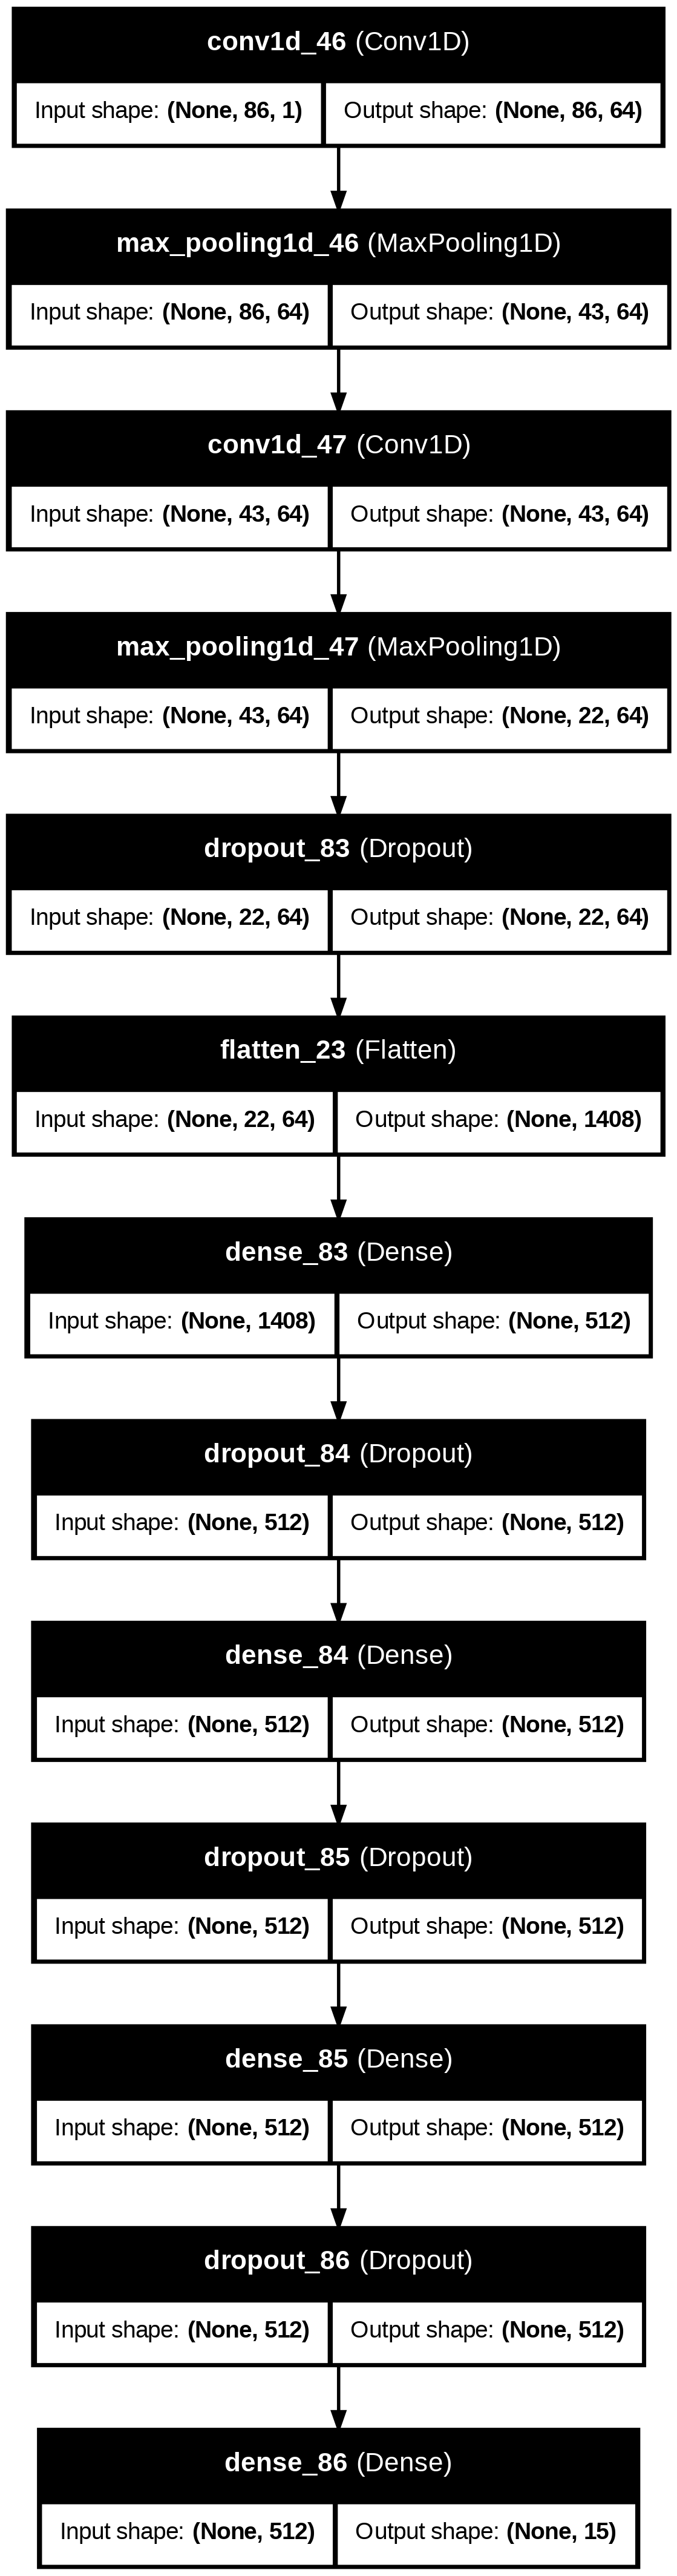

In [17]:
# Vẽ kiến trúc mô hình
plot_model(best_model, to_file='cnn_pso_model.png', show_shapes=True, show_layer_names=True)

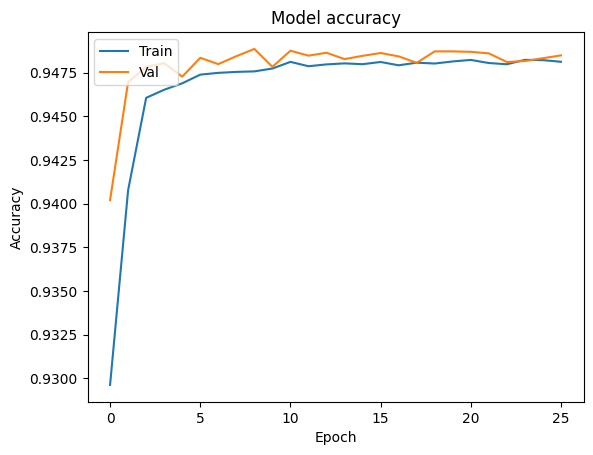

<Figure size 640x480 with 0 Axes>

In [18]:
# Vẽ biểu đồ độ chính xác huấn luyện và xác thực
plt.plot(best_model_history['accuracy'])
plt.plot(best_model_history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('acc_plot.png')

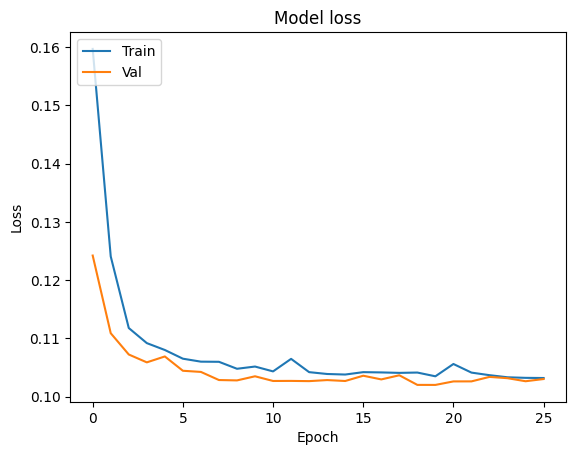

<Figure size 640x480 with 0 Axes>

In [19]:
# Vẽ biểu đồ mất mát huấn luyện và xác thực
plt.plot(best_model_history['loss'])
plt.plot(best_model_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('los_plot.png')

In [20]:
# Đánh giá mô hình trên tập huấn luyện
train_metrics = best_model.evaluate(X_train, y_train, verbose=1)

42036/42036 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.9483 - f1_score: 0.7944 - loss: 0.1023 - precision_23: 0.9827 - recall_23: 0.9235


In [21]:
# Đánh giá mô hình trên tập xác thực
val_metrics = best_model.evaluate(X_val, y_val, verbose=1)

6006/6006 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9477 - f1_score: 0.7940 - loss: 0.1038 - precision_23: 0.9829 - recall_23: 0.9227


In [22]:
# Đánh giá mô hình trên tập kiểm tra
start_time = time.time()
print("Model performance on test dataset:")
test_metrics = best_model.evaluate(X_test, y_test, verbose=1)
end_time = time.time()
test_time = end_time - start_time
print(f"Testing time: {test_time:.2f} giây")

Model performance on test dataset:
12011/12011 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9482 - f1_score: 0.7953 - loss: 0.1023 - precision_23: 0.9830 - recall_23: 0.9235
Testing time: 26.50 giây


In [23]:
# Dự đoán trên tập kiểm tra
start_time = time.time()
y_pred = best_model.predict(X_test)
total_inference_time = time.time() - start_time
print(f"\nTổng thời gian dự đoán cho tập kiểm tra: {total_inference_time:.4f} giây")

12011/12011 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step

Tổng thời gian dự đoán cho tập kiểm tra: 23.5196 giây


In [24]:
# Tính thời gian suy luận trung bình cho mỗi mẫu
num_samples = X_test.shape[0]
avg_inference_time = (total_inference_time / num_samples) * 1000  # chuyển đổi sang mili giây
print(f"\nThời gian suy luận trung bình trên mỗi mẫu: {avg_inference_time:.6f} ms")


Thời gian suy luận trung bình trên mỗi mẫu: 0.061196 ms


In [25]:
# Báo cáo phân loại
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      4805
           1       0.76      0.92      0.84      9709
           2       1.00      0.99      0.99     13588
           3       0.81      1.00      0.89     10013
           4       1.00      1.00      1.00     24314
           5       0.90      0.70      0.79      1706
           6       1.00      1.00      1.00       712
           7       1.00      1.00      1.00    272800
           8       0.91      0.18      0.30      9987
           9       1.00      0.49      0.66      3995
          10       0.96      0.92      0.94      2156
          11       0.91      0.19      0.31     10165
          12       1.00      0.28      0.44      7361
          13       1.00      0.84      0.91     10005
          14       0.62      0.29      0.39      3013

   micro avg       0.98      0.92      0.95    384329
   macro avg       0.92      0.71      0.76    384329
weighted avg       0.98   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


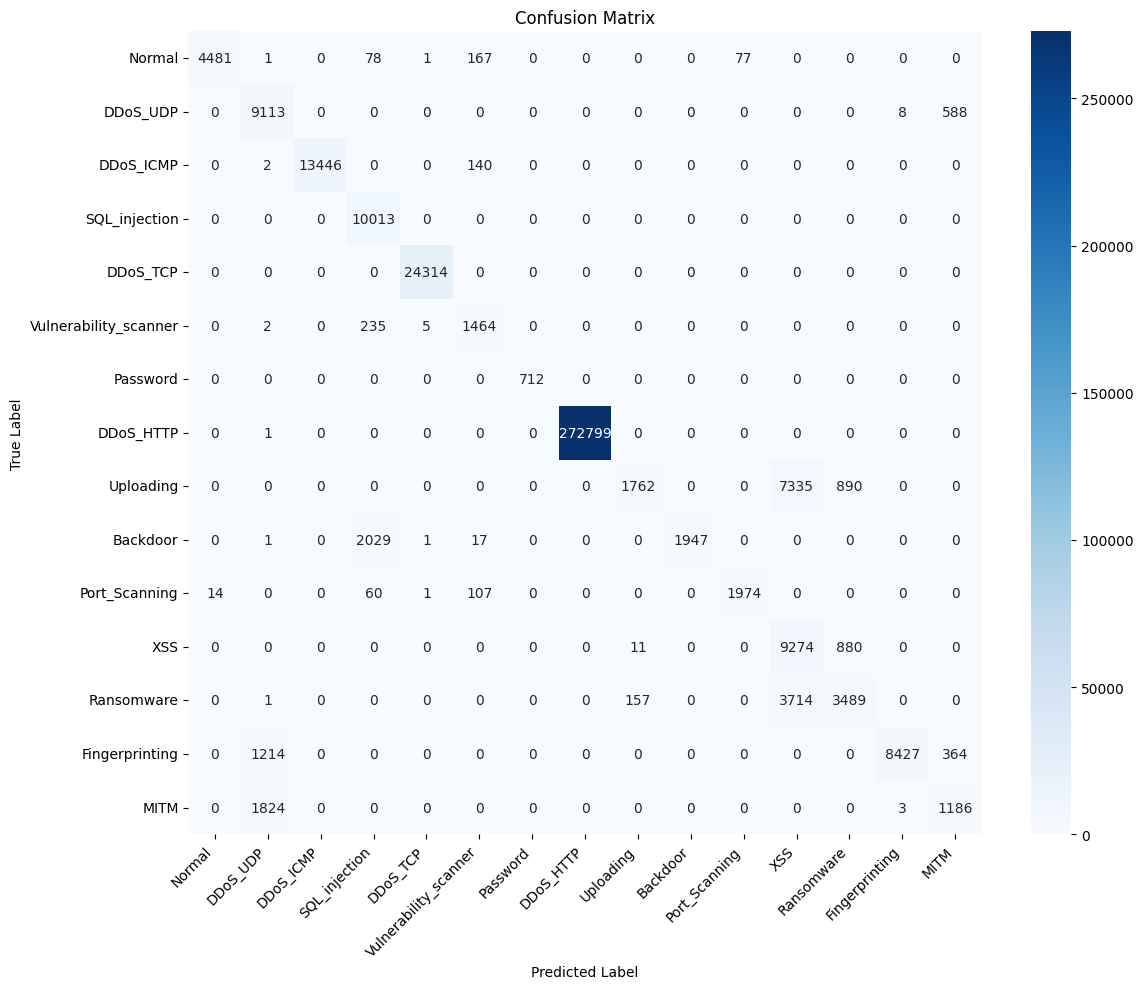

In [26]:
# Ma trận nhầm lẫn
# Lấy nhãn các lớp
class_labels = [
    'Normal', 'DDoS_UDP', 'DDoS_ICMP', 'SQL_injection', 'DDoS_TCP', 
    'Vulnerability_scanner', 'Password', 'DDoS_HTTP', 'Uploading', 
    'Backdoor', 'Port_Scanning', 'XSS', 'Ransomware', 
    'Fingerprinting', 'MITM'
]

# Chuyển đổi dự đoán sang nhãn lớp
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Tạo ma trận nhầm lẫn
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(12, 10))  # Điều chỉnh kích thước để hiển thị rõ
sns.heatmap(
    conf_mat, 
    annot=True,  # Hiển thị số lượng 
    fmt='d',     # Định dạng số nguyên
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()  # Điều chỉnh bố cục để không bị cắt nhãn
plt.savefig('confusion_matrix.png')
plt.show()

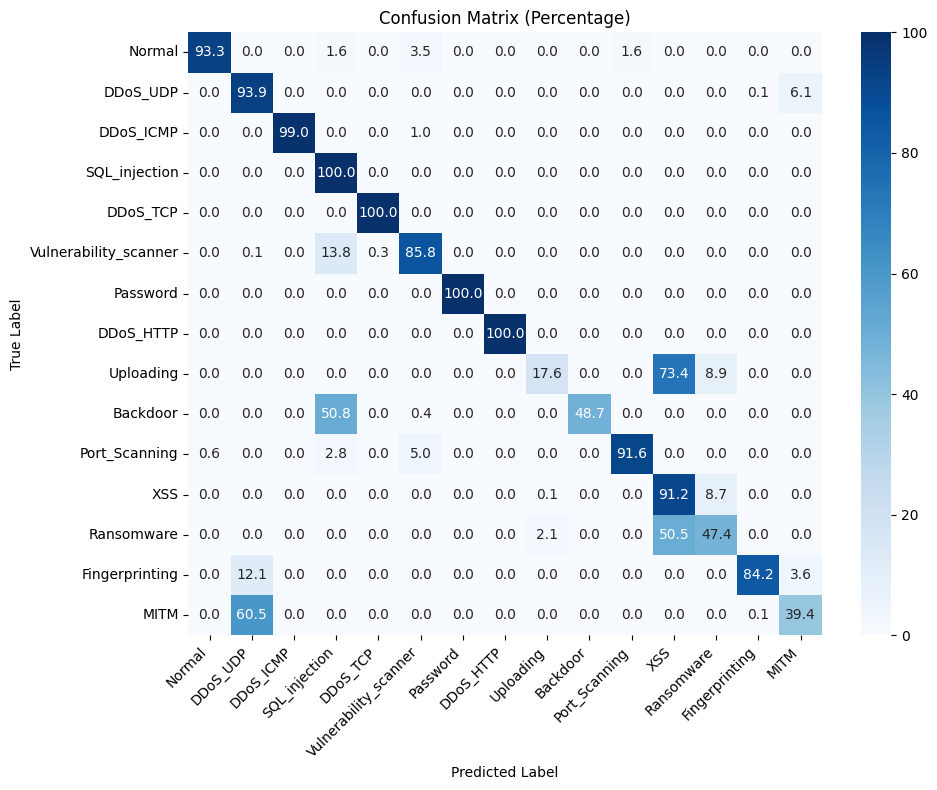

In [27]:
# Ma trận nhầm lẫn với tỷ lệ phần trăm
# Chuyển đổi sang tỷ lệ phần trăm
conf_mat_percent = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))  # Tăng kích thước để hiển thị rõ
sns.heatmap(
    conf_mat_percent, 
    annot=True,  # Hiển thị số liệu 
    fmt='.1f',   # Định dạng 1 chữ số thập phân
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()  # Điều chỉnh bố cục để không bị cắt nhãn
plt.savefig('confusion_matrix_percentage.png')
plt.show()

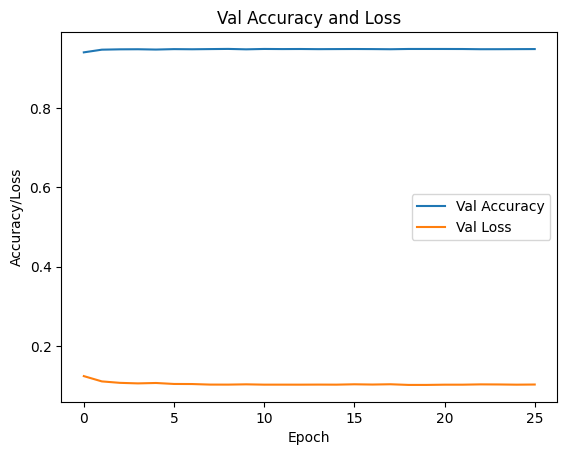

<Figure size 640x480 with 0 Axes>

In [28]:
# Độ chính xác và mất mát trên tập kiểm tra qua các epoch
test_acc = best_model_history['val_accuracy']
test_loss = best_model_history['val_loss']
plt.plot(test_acc, label='Val Accuracy')
plt.plot(test_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.title('Val Accuracy and Loss')
plt.legend()
plt.show()
plt.savefig('val_acc_los.png')